# Intro

In this script we will work on finding a good model nad optimal ammount of clusters for precomputed set of centroid distances for each image. (For more information head to Generate_depth10_allPixels file)

# Libraries and Set

In [1]:
from visualizations import *
import numpy as np
import pandas as pd
import warnings
from math import tau
import matplotlib.pyplot as plt
from scipy.integrate import quad
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')

In [6]:
centroid_distances = np.load('centroid_distances.npy') # thats our frame of 30-dimensional points to compare with each other via clustering

labels[i] correspond to centroid_distances[i]

# Searching for optimal clusters number in aglomerative

In [95]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

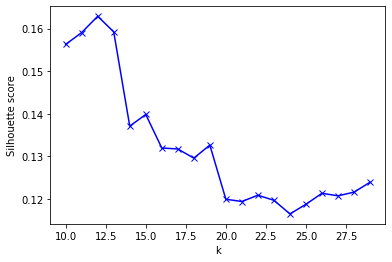

In [83]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

model_test = AgglomerativeClustering
cluster_num_seq = range(10, 30) # minimum 10 clusters
silhouette_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### So silhouette score suggests to use 12 clusters, let's check it then

In [84]:
model = AgglomerativeClustering(n_clusters=12, linkage='ward')
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=12,
                        pooling_func='deprecated')

In [85]:
model.labels_

array([ 2,  5, 10, ...,  6,  8,  5], dtype=int64)

### Testing model

In [91]:
np.unique(labels[model.labels_ == 0], return_counts=True)

(array([2, 3, 4, 5, 7, 8, 9]),
 array([  9,   3,   1,   2,  57,   2, 132], dtype=int64))

# Searching for optimal clusters in KMeans

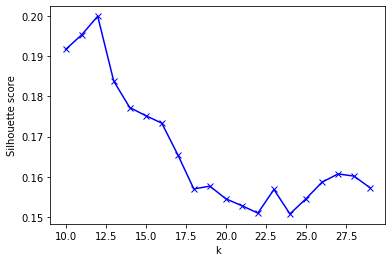

In [96]:
from sklearn.cluster import KMeans

model_test = KMeans
cluster_num_seq = range(10, 30) # minimum 10 clusters
silhouette_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Better results than agglomerative

### Testing model

In [103]:
model = KMeans(n_clusters=12)
model.fit(centroid_distances)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [110]:
np.unique(labels[model.labels_ == 3], return_counts=True)

(array([2, 4, 5, 7, 8, 9]), array([ 17, 102,   6,   4,   3,   1], dtype=int64))

# But is silhoutte score that good for our model?

It would be much better to test our own scorer - how much is a cluster dominated by one number

In [131]:
def dominanceOfPredictedClusters(labels_pred, labels_true):
    clusters = np.unique(labels_pred)
    cluster_dominance = []
    cluster_sizes = []
    N = len(labels_pred)
    for l in clusters:
        labels_in_cluster = np.bincount(labels[np.where(labels_pred==l)])
        cluster_dominance.append(np.max(labels_in_cluster)/np.sum(labels_in_cluster))
        cluster_sizes.append(len(labels[np.where(labels_pred==l)]))
    # mean needs to be counted with wages, to omit situation when all but one clusters are super balanced
    return np.average(cluster_dominance, weights=cluster_sizes)
# the closer it is to one, the more dominated the clusters are, meaning the better is our model

In [155]:
def count_clustering_scores(X, cluster_num, model, score_fun, labels_true):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        model_instance.fit(X)
        dominance = dominanceOfPredictedClusters(model_instance.labels_, labels_true)
        scores.append(dominance)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

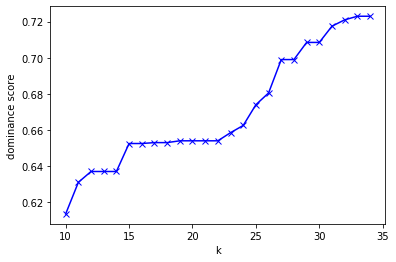

In [152]:
from sklearn.cluster import AgglomerativeClustering

model_test = AgglomerativeClustering
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

# we received a peak at k = 33 lets test it

In [140]:
model = AgglomerativeClustering(n_clusters=32, linkage = 'ward')
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=32,
                        pooling_func='deprecated')

In [153]:
np.unique(labels[model.labels_ == 9], return_counts=True)

(array([2, 3, 7, 8, 9]), array([ 2,  4, 60,  1,  3], dtype=int64))

# Checking KMeans

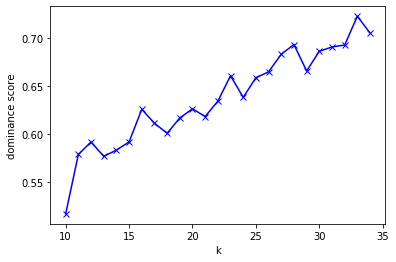

In [156]:
from sklearn.cluster import KMeans

model_test = KMeans
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()